In [1]:
#LLAMANDO LIBRERIAS DE LENSTRONOMY
import numpy as np
import time
import corner
import matplotlib.pyplot as plt
import matplotlib
import os
import copy
import astropy.io.fits as pyfits


from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Plots.output_plots as lens_plot

from lenstronomy.Util import constants

import lenstronomy.Util.param_util as param_util

from lenstronomy.ImSim.image_model import ImageModel

from lenstronomy.PointSource.point_source import PointSource

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

from lenstronomy.LightModel.light_model import LightModel

from lenstronomy.Sampling.parameters import Param

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

from lenstronomy.Cosmo.lens_cosmo import LensCosmo

from astropy.cosmology import FlatLambdaCDM

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# VAMOS A REALIZAR LA CONSTRUCCION DEL LENTE USANDO SPEMD, SHEAR DEBIDO A QUE SABEMOS LOS RESULTADOS DEL RUNG0
# SIN EMBARGO ES NECESARIO REALIZARLOS HACIENDO LAS COMBINACIONES NECESARIAS

# Con la ayuda de IRAF deterinamos la ubicacion en pixeles, sabiendo que cada pixel son 0.08" para drizzzle images
# el centro esta ubicado en pixeles x = 49 y = 49
x_A = 0.12
x_B = -1.08
x_C = 1.28
x_D = -0.21

y_A = -1.01
y_B = -0.2
y_C = 0.29
y_D = 1.15
# unidades en segundos de arco

# definimos valores de excentricidades completamente arbitrarios, incialmente
# pilas existen diferente tipos de excentricidades
# excentricidad para la lente, excentricidad de la fuente y excentricidad para el perfil de luz
# Determinamos phi de cada estrella, en teoria es el mismo para todos

# Definimos elipticidades e1, e2 de la masa de la lente
q = 0.8690225
phi=1.751415
#Transformacion
e1, e2 = param_util.phi_q2_ellipticity(phi=phi, q=q)

# Definimos redshift de la fuente y de la lente
z_source = 2.175
z_lens = 0.858

# Definimos algun tipo de cosmologia, aproximada
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)
lensCosmo = LensCosmo(cosmo=cosmo, z_lens=z_lens, z_source=z_source)

# Definimos lente mas basica tipo SPEMD, Incialmente sin perfil de luz, ni cizallamiento SHEAR.
lens_model_list = ['SPEMD']
lensModel = LensModel(lens_model_list=lens_model_list, cosmo=cosmo, z_lens=z_lens, z_source=z_source)
lensModelExtensions = LensModelExtensions(lensModel=lensModel)
lensEquationSolver = LensEquationSolver(lensModel=lensModel)
# Definimos caracteristicas basicas lente.
kwargs_spemd = {'theta_E':1.169016681,'gamma':2,'center_x':0,'center_y':0,'e1':e1,'e2':e2}
kwargs_lens = [kwargs_spemd]

# Debemos determinar la unicacion de la fuente, esto lo hacemos determinando Theta mediante inversion
# Al parecer escogemos en base a una unica lente, determinamos RA y DEC.

# Definimos ubicacion del lente. 
theta_ra, theta_dec = -0.25, 1.07

beta_ra, beta_dec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)

x_source = beta_ra
y_source = beta_dec  


print(beta_ra)
print (beta_dec)



0.014797778881058321
-0.03886729319465676


image positions are:  [ 1.18851527 -0.97882962  0.09006239 -0.25      ] [-0.22409871 -0.68636804 -1.17696018  1.07      ]
point source magnification:  [ 11.83517785  14.62230176 -16.54915531  -7.10766867]
source size in arcsec:  0.0006038368763800474
finite magnification:  [11.83458472 14.62914177 16.55146004  7.10645772]
time delays:  [-131.54003751 -128.5114066  -125.27960628 -108.51791596]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10


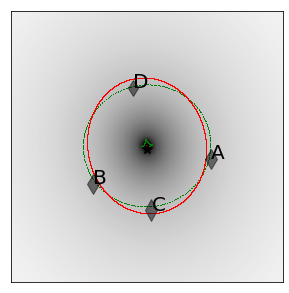

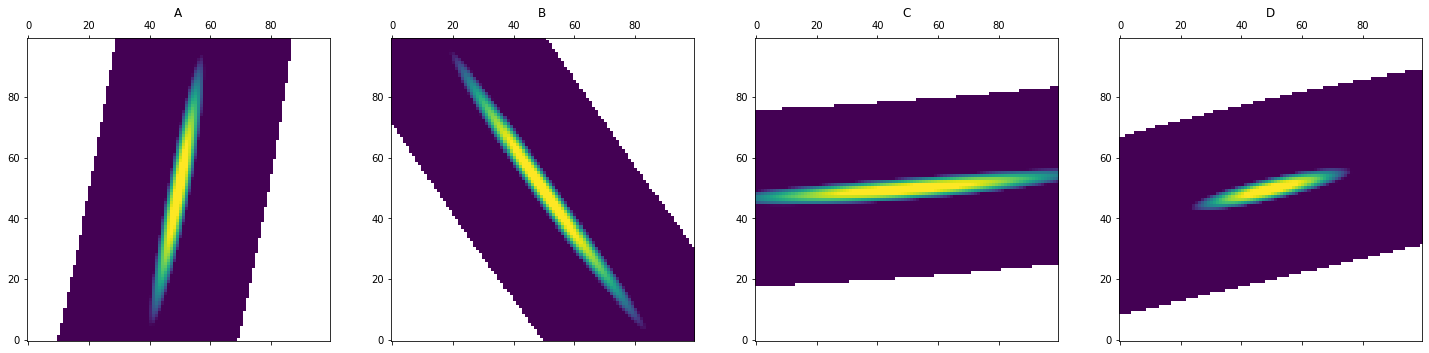

In [3]:
# DATOS PARA EL MODELAMIENTO DE LA LENTE, NO DEBEN MODIFICARSE, ESTA LINEA DE CODIGO NOS MUESTRA LA LENTE. 
# compute image positions and their (finite) magnifications

# we solve for the image position(s) of the provided source position and lens model
x_img, y_img = lensEquationSolver.image_position_from_source(kwargs_lens=kwargs_lens, sourcePos_x=x_source, 
                                                             sourcePos_y=y_source)
print('image positions are: ', x_img, y_img)
# the infinitesimal magnification at the position of the images is:
mag_inf = lensModel.magnification(x_img, y_img, kwargs_lens)
print('point source magnification: ', mag_inf)


# we chose a finite source size of the emitting 'point source' region
source_size_pc = 5. # Gaussian source size in units of parsec
# we convert the units of pc into arcseconds given the redshift of the lens and the cosmology
D_s = lensCosmo.D_s
source_size_arcsec = source_size_pc / 10**6 / D_s / constants.arcsec
print('source size in arcsec: ', source_size_arcsec)

# we compute the finite magnification by rendering a grid around the point source position and add up all the flux coming from the extended source in this window
window_size = 0.08  # units of arcseconds
grid_number = 100  # supersampled window (per axis)

# and here are the finite magnifications computed
mag_finite = lensModelExtensions.magnification_finite(x_pos=x_img, y_pos=y_img, kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
print('finite magnification: ', mag_finite)



# here are the predicted time delays in units of days
t_days = lensModel.arrival_time(x_img, y_img, kwargs_lens)
print('time delays: ', t_days)

# here we plot the lens model, including (optional) the caustics and critical curves
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=x_source, sourcePos_y=y_source, point_source=True, with_caustics=True)
f.show()


# here we plot the finite sources as seen at the different image positions
f, axes = plt.subplots(1, len(x_img), figsize=(5*5, 5*len(x_img)), sharex=False, sharey=False)
label_list = ['A', 'B', 'C', 'D']
for i in range(len(x_img)):
    image = lensModelExtensions.zoom_source(x_pos=x_img[i], y_pos=y_img[i], kwargs_lens=kwargs_lens, 
                                                      source_sigma=source_size_arcsec, window_size=window_size,
                                                      grid_number=grid_number)
    ax = axes[i]
    ax.matshow(np.log10(image), vmin=0, vmax=5, origin='lower')
    ax.set_title(label_list[i])
plt.show()